
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #AlexNet takes 224x224 input image
    transforms.ToTensor(), #scales values to [0-1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #AlexNet takes 224x224 input image
    transforms.ToTensor(), #scales values to [0-1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech #(new dataset with __init__, __len__, __get_item__ not needed) 
import sklearn.model_selection as ms
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes, val_indexes = ms.train_test_split(list(range(train_dataset.__len__())), train_size=0.5)  # split the indices for your train and validation (on train set) split
#cross-validation is too much expensive, so we set a validation set at the beginning

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 3048
Valid Dataset: 3048
Test Dataset: 3049


**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [6]:
net = resnet50() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

#freeze layers except for the last
for param in net.parameters():
    param.requires_grad = False

for param in net.fc.parameters():
    param.requires_grad = True

**Prepare Training**

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: net.features.parameters()
parameters_to_optimize = net.fc.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) #weight decay is L2 optimization 

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) #every step epochs (step_size) we decrease LR by gamma

**Train**

In [8]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
losses = []
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))


  net.train() # Sets module in training mode

  # Iterate over the dataset
  for images, labels in train_dataloader: #loads batches --> list of tuples (image, label)
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    losses.append(loss.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() #end of an epoch

c:\Users\Utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.826259613037109
Step 10, Loss 4.558393478393555
Starting epoch 2/30, LR = [0.001]
Step 20, Loss 4.094080924987793
Starting epoch 3/30, LR = [0.001]
Step 30, Loss 4.091447353363037
Starting epoch 4/30, LR = [0.001]
Step 40, Loss 4.134493827819824
Starting epoch 5/30, LR = [0.001]
Step 50, Loss 3.9805386066436768
Starting epoch 6/30, LR = [0.001]
Step 60, Loss 3.9672107696533203
Starting epoch 7/30, LR = [0.001]
Step 70, Loss 4.070749759674072
Starting epoch 8/30, LR = [0.001]
Step 80, Loss 3.9613640308380127
Starting epoch 9/30, LR = [0.001]
Step 90, Loss 3.9819982051849365
Starting epoch 10/30, LR = [0.001]
Step 100, Loss 3.912431478500366
Starting epoch 11/30, LR = [0.001]
Step 110, Loss 4.003281116485596
Step 120, Loss 3.921891689300537
Starting epoch 12/30, LR = [0.001]
Step 130, Loss 3.9702863693237305
Starting epoch 13/30, LR = [0.001]
Step 140, Loss 3.879603385925293
Starting epoch 14/30, LR = [0.001]
Step 150, Loss 4.0349903106689

**plot loss**

Text(0, 0.5, 'Loss')

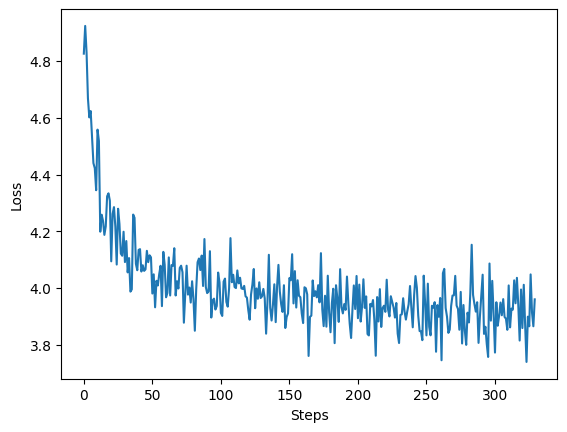

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')

**Validation**

In [13]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.eval() # Set Network to evaluation mode

with torch.no_grad():
  running_corrects = 0
  for i, (images, labels) in enumerate(val_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels)


# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

Validation Accuracy: 0.16076114773750305


**Test**

In [14]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.eval() # Set Network to evaluation mode

with torch.no_grad():
  running_corrects = 0
  for i, (images, labels) in enumerate(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()


# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

Test Accuracy: 0.1620203345359134
